# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__16 марта 00:00__</span>.

Мягкий дедлайн: <span style="color:red">__30 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `Unet` и `Linknet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [148]:
# import zipfile
# from tqdm import tqdm

# fname = "./people_data.zip"
# path = "./"

# with zipfile.ZipFile(fname, "r") as zf:
#     for entry in tqdm(zf.infolist()):
#         try:
#             zf.extract(entry, path)
#         except zipfile.error as e:
#             pass

In [149]:
# %pip install torchvision

In [592]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader

# import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')                      don't work in collab:(

%config InlineBackend.figure_format = 'svg'

In [593]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        # your code here
        import os

        self.img_paths = []
        self.target_paths = []
        for image in sorted(os.listdir(images_dir)):
            self.img_paths.append(images_dir + image)
        if target_dir is not None:
            for img in sorted(os.listdir(target_dir)):
                self.target_paths.append(target_dir + img)
        self.transforms = transforms
        
    def __len__(self):
        # your code here
        return len(self.img_paths)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        # your code here
        from PIL import Image
        from torchvision.io import read_image
        
        img_name = self.img_paths[idx]
        target_name = self.target_paths[idx]
        # sample = (
        #     np.asarray(Image.open(img_name)),
        #     np.asarray(Image.open(target_name)),
        # )
        # sample = (read_image(img_name).to(torch.float), read_image(target_name).to(torch.float))
        sample = (read_image(img_name).float(), read_image(target_name).float())

        if self.transforms is not None:
            sample = self.transforms(sample)
        return sample

In [457]:
# from google.colab import drive
# drive.mount('/content/drive')

In [594]:
DATA_PATH  = "./people_data/" #'/content/drive/MyDrive/Данные/people_data/' #r'C:\Users\Дарья\Documents\people_data/'
train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    # transforms= img_tr
)
test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    # transforms= test_tr
)

In [595]:
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=1)

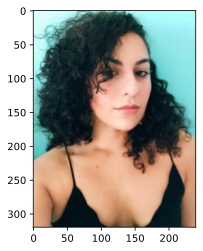

torch.Size([1, 1, 320, 240])


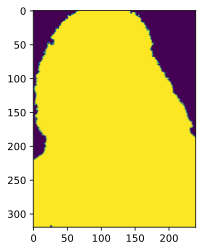

In [596]:
img_test, mask_test = next(iter(train_data_loader))

# print(img_test)
plt.imshow(img_test[0].permute(1, 2, 0).to(torch.uint8) )
plt.show()
print(mask_test.shape)
plt.imshow(mask_test[0][0] )
plt.show()

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
* случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
* случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

In [597]:
# your code here
import torchvision.transforms.functional as F

class  RandomHorizontalFlip_my(object):
    """
    случайное (с вероятностью  p ) горизонтальное отображение (flip) изображения
    """
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img_mask):
        img = img_mask[0]
        mask = img_mask[1]
        if torch.rand(1) < self.p:
            if mask is not None:
                return F.hflip(img), F.hflip(mask)
            else:
                return F.hflip(img), None
        return img, mask


In [428]:
# hor_flip = RandomHorizontalFlip_my(1)
# print(img_test.shape)
# img_test_1, mask_test_1 = hor_flip((img_test[0], mask_test[0]))
# print(img_test_1.shape)
# plt.imshow(img_test_1.permute(1, 2, 0).to(torch.uint8))
# plt.show()

# plt.imshow(mask_test_1[0])
# plt.show()

In [598]:
class RandomCrop_my(object):
    """
   случайное (с вероятностью  p ) вырезание фрагмента изображения (заданного или случайного размера)
    """
    def __init__(self, p=0.5, size=None):
        self.p = p
        self.size = size

    def __call__(self, img_mask):
        img = img_mask[0]
        mask = img_mask[1]
        if torch.rand(1) < self.p:
            max_high = img.shape[1]   #320
            max_width = img.shape[2]  #240
            if self.size is None:
                 self.size = (np.random.randint(20, high=50, size=1)[0], np.random.randint(20, high=50, size=1)[0])
#             print(self.size)
            x = np.random.randint(0, high=max_high, size=1)[0]  #пусть это будет случайный левый верхний угол закрашиваемой области
            y = np.random.randint(0, high=max_width, size=1)[0]
#             print(x, y)
            img[0][x:x+self.size[0], y:y+self.size[1]] = 0
            img[1][x:x+self.size[0], y:y+self.size[1]] = 0
            img[2][x:x+self.size[0], y:y+self.size[1]] = 0
            mask[0][x:x+self.size[0], y:y+self.size[1]] = 0
        return img, mask


In [575]:
# trans =  RandomCrop_my(1)
# img_test_1, mask_test_1 = trans((img_test[0], mask_test[0]))
# # print(img_test_1.shape)
# plt.imshow(img_test_1.permute(1, 2, 0).to(torch.uint8))
# plt.show()

# plt.imshow(mask_test_1[0])
# plt.show()

In [599]:
class RandomBright(object):
    """
    случайное (с вероятностью  p ) изменение яркости изображения (на заданную или случайную величину)
    """
    def __init__(self, p=0.5, change=None):
        self.p = p
        self.bright = change


    def __call__(self, img_mask):
        img = img_mask[0].to(torch.uint8)
        mask = img_mask[1]
        if torch.rand(1) < self.p:
            if self.bright is None:
                self.bright = 3*torch.rand(1)
            return F.adjust_brightness(img, self.bright), mask
        return img, mask

In [508]:
# trans = RandomBright(1, 2)
# # print(mask_test[0].shape)
# img_test_1, mask_test_1 = trans((img_test[0], mask_test[0]))
# # print(img_test_1.shape)
# plt.imshow(img_test_1.permute(1, 2, 0).to(torch.uint8))
# plt.show()

# plt.imshow(mask_test_1[0])
# plt.show()

In [600]:
class RandomChangeBack(object):
    """
    случайное (с вероятностью  p ) изменение фона изображения (на изображение из заданного списка изображений)
    """
    def __init__(self, p=0.5):
        self.p = p
        # self.imgs = [r"C:\Users\Дарья\Documents\for lab_2\1.jpg",
        #              r"C:\Users\Дарья\Documents\for lab_2\2.jpg",
        #              r"C:\Users\Дарья\Documents\for lab_2\3.jpg"]
#         self.imgs = ['/content/drive/MyDrive/Данные/backgrounds/1.jpg',
#                      '/content/drive/MyDrive/Данные/backgrounds/2.jpg',
#                      '/content/drive/MyDrive/Данные/backgrounds/3.jpg']
        self.imgs = [ "./1.jpg",
                      "./2.jpg",
                      "./3.jpg"]

    def __call__(self, img_mask):
        img = img_mask[0]
        mask = img_mask[1]
        if torch.rand(1) < self.p:
            from torchvision.io import read_image

            idx = np.random.randint(0, high=2, size=1)
            backgr_img = read_image(self.imgs[idx[0]]).to(torch.float)
            img[0][mask[0]!=255] = backgr_img[0][mask[0]!=255]
            img[1][mask[0]!=255] = backgr_img[1][mask[0]!=255]
            img[2][mask[0]!=255] = backgr_img[2][mask[0]!=255]
            return img, mask
        return img, mask

In [433]:
# trans = RandomChangeBack(1)
# img_test_1, mask_test_1 = trans((img_test[0], mask_test[0]))
# # print(img_test_1.shape)
# plt.imshow(img_test_1.permute(1, 2, 0).to(torch.uint8))
# plt.show()

# plt.imshow(mask_test_1[0])
# plt.show()

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [601]:
class Normalize_my(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std= std

    def __call__(self, img_mask):
        img = img_mask[0].float()
        mask = img_mask[1].float()
        mask = mask / 255
        t = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
        img = t(img / 255)
        return img, mask

In [435]:
# class Tensor_my(object):
#     def __call__(self, img_mask):
#         img = img_mask[0] # .float()
#         mask = img_mask[1] #.to(torch.float)
#         tr = transforms.ToTensor()
#         return tr(img), tr(mask) 


In [511]:
DATA_PATH = "./people_data/" #'/content/drive/MyDrive/Данные/people_data/' #r'C:\Users\Дарья\Documents\people_data/' # your path

from torchvision import transforms
train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= transforms.Compose([
                                    # RandomChangeBack(),
                                    # RandomBright(0.5, 3),
                                    # RandomHorizontalFlip_my(),
                                    Normalize_my(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ]) # your code here
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms=transforms.Compose([  Normalize_my(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                   ]) # your code here
)

Функция для отображения изображения:

In [602]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

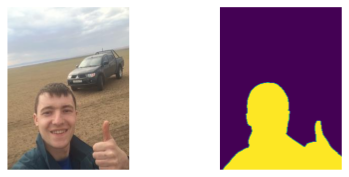

In [513]:
# your code here
show_idx_image(train_dataset, 10)

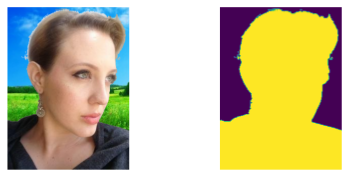

In [514]:
train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= transforms.Compose([
                                    RandomChangeBack(1),
                                    # RandomBright(0.5, 3),
                                    # RandomHorizontalFlip_my(),
                                    Normalize_my(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                                     transforms.ToTensor()
                                    ]) # your code here
                              )

show_idx_image(train_dataset, 2)

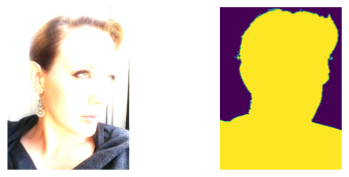

In [515]:
train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= transforms.Compose([
                                    # RandomChangeBack(1),
                                    RandomBright(1, 2),
                                    # RandomHorizontalFlip_my(),
                                    Normalize_my(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ]) # your code here
                              )

show_idx_image(train_dataset, 2)

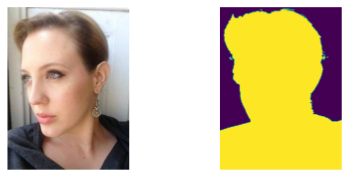

In [516]:
train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= transforms.Compose([
                                    # RandomChangeBack(1),
                                    # RandomBright(0.5, 3),
                                    RandomHorizontalFlip_my(1),
                                    Normalize_my(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ]) # your code here
                              )

show_idx_image(train_dataset, 2)

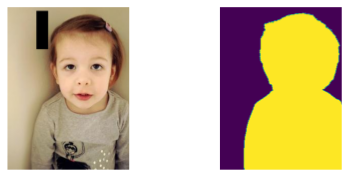

In [520]:
train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= transforms.Compose([
                                    RandomCrop_my(1),
                                    # RandomChangeBack(1),
                                    # RandomBright(0.5, 3),
                                    # RandomHorizontalFlip_my(),
                                    Normalize_my(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ]) # your code here
                              )

show_idx_image(train_dataset, 3)

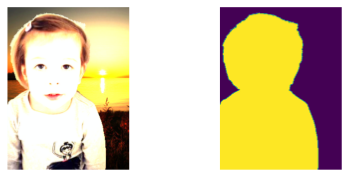

In [603]:
DATA_PATH = "./people_data/" #'/content/drive/MyDrive/Данные/people_data/' #r'C:\Users\Дарья\Documents\people_data/' # your path

from torchvision import transforms
train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms= transforms.Compose([
                                    RandomChangeBack(),
                                    RandomBright(),
                                    RandomHorizontalFlip_my(),
                                    Normalize_my(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ]) # your code here
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms=transforms.Compose([ Normalize_my(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                   ]) # your code here
)

show_idx_image(train_dataset, 3)

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

In [604]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [605]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        # your code here
        numer = logits*true_labels
        numer = 2*numer.sum((-1, -2))
        denom = logits + true_labels + self.eps
        res = 1 - numer / denom.sum((-1, -2))
        
        if self.reduction == 'sum':
            loss_value = res.sum() # your code
        elif self.reduction == 'mean':
            loss_value = res.sum() / logits.shape[0]# your code
        elif self.reduction is None:
            loss_value = res # your code
            
        return loss_value

Проверка реализации:

In [606]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать [UNet](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`. Архитектура сети реализована за вас ниже.

Энкодер:

In [607]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[
                    feature_extractor[j]
                    for j in range(i * 5, i * 5 + 4)
                ])
            )

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [608]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [609]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [610]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [611]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            correct += float(val_criterion(outputs, labels).detach())
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

In [ ]:
#!g1.1
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [637]:
#!g1.1    
class iou(nn.Module):
    def __init__(self, eps=1e-7, with_logits=True):
        super().__init__()
        self.SMOOTH = eps
        self.with_logits = with_logits
    
    def forward(self, outputs, labels):
        labels = labels.long()

        if self.with_logits:
            outputs = torch.sigmoid(outputs)

        intersection = ((outputs > 0.5) & (labels == 1)).float().sum((-1, -2))  
        union = ((outputs > 0.5) | (labels == 1)).float().sum((-1, -2))       

        iou = ((intersection + self.SMOOTH) / (union + self.SMOOTH)).sum()
    
        return iou

In [612]:
#!g1.1
def plt_graphics(verbose_data, title):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(15)

    plt.subplot(1, 2, 1)
    plt.suptitle(title)
    plt.plot(verbose_data['train_verbose_steps'],
             verbose_data['train_loss'], 'b', linewidth=2)
    plt.plot(verbose_data['test_verbose_steps'],
             verbose_data['test_loss'], 'r', linewidth=2)
    plt.legend(['train', 'test'], fontsize=14)

    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(verbose_data['test_verbose_steps'],
             verbose_data['test_accuracy'], 'r', linewidth=2)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('accuracy', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    plt.grid()
    plt.show()


def optimize_net(net, optimizer, criterion, val_criterion,
                 trainloader, testloader, device, n_epochs=20,
                 use_cuda=True, verbose=True, batch_verbose_proportion=0.5, 
                 verbose_data=None):
    net = net.to(device)
#     net = net.train()
    
    n_batches = len(trainloader)
    n_batches_for_verbose = int(n_batches * batch_verbose_proportion)    
    
    
    if verbose_data is None:
        verbose_data = {
            'train_verbose_steps': [],
            'train_loss': [],
            'test_verbose_steps': [],
            'test_loss': [],
            'test_accuracy': [],
        }
    
    # loop over the dataset multiple times
    for epoch in range(n_epochs): 
        net = net.train()
        running_loss = 0.0
        total_objects = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
        
            # move data to cuda if need
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += float(loss) #?
            total_objects += outputs.shape[0]
            
            
            # save info sometimes
            if i % n_batches_for_verbose == n_batches_for_verbose - 1:
                epoch_value = epoch + np.around(i / n_batches, 2)
                new_train_loss = running_loss / total_objects
                running_loss = 0
                total_objects = 0
                
                verbose_data['train_verbose_steps'].append(epoch_value)
                verbose_data['train_loss'].append(new_train_loss * 100)    
                
                if verbose:
                    print(
                        '[{:.2f}] loss: {:.3f}'
                        .format(epoch_value, new_train_loss)
#                         .format(epoch_value, running_loss / n_batches_for_verbose)
                    )
                
#                 if verbose:
#                     plt_graphics(verbose_data)
                
        # save info about test 
        test_loss, test_accuracy = evaluate_net(net, testloader, criterion, val_criterion, device=device)
        verbose_data['test_verbose_steps'].append(epoch + 1)
        verbose_data['test_loss'].append(test_loss * 100)
        verbose_data['test_accuracy'].append(test_accuracy * 100)
        
                
        if verbose:
            print(
                '[{}] test_accuracy: {:.3f}, test_loss: {:.3f}'
                .format(epoch + 1, test_accuracy, test_loss)
            )
            print('------------------------------')
            
#     if verbose:
#         plt_graphics(verbose_data)
    if verbose:
        print('Finished Training')
            
    return verbose_data

In [657]:
#!g1.1
# your code here
import torch.optim as optim
unet = UNet()
criterion_logloss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-4, weight_decay=1e-4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

unet_logloss_data = optimize_net(
    unet, optimizer, criterion_logloss, iou(),
    train_data_loader, test_data_loader, 
    n_epochs=20, device=device
)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg13-19584684.pth



[0.49] loss: 0.045
[0.99] loss: 0.024
[1] test_accuracy: 0.840, test_loss: 0.032
------------------------------
[1.49] loss: 0.022
[1.99] loss: 0.021
[2] test_accuracy: 0.858, test_loss: 0.032
------------------------------
[2.49] loss: 0.018
[2.99] loss: 0.018
[3] test_accuracy: 0.896, test_loss: 0.021
------------------------------
[3.49] loss: 0.015
[3.99] loss: 0.017
[4] test_accuracy: 0.884, test_loss: 0.024
------------------------------
[4.49] loss: 0.015
[4.99] loss: 0.014
[5] test_accuracy: 0.896, test_loss: 0.022
------------------------------
[5.49] loss: 0.013
[5.99] loss: 0.013
[6] test_accuracy: 0.911, test_loss: 0.018
------------------------------
[6.49] loss: 0.012
[6.99] loss: 0.012
[7] test_accuracy: 0.894, test_loss: 0.023
------------------------------
[7.49] loss: 0.012
[7.99] loss: 0.012
[8] test_accuracy: 0.906, test_loss: 0.019
------------------------------
[8.49] loss: 0.010
[8.99] loss: 0.011
[9] test_accuracy: 0.910, test_loss: 0.018
----------------------

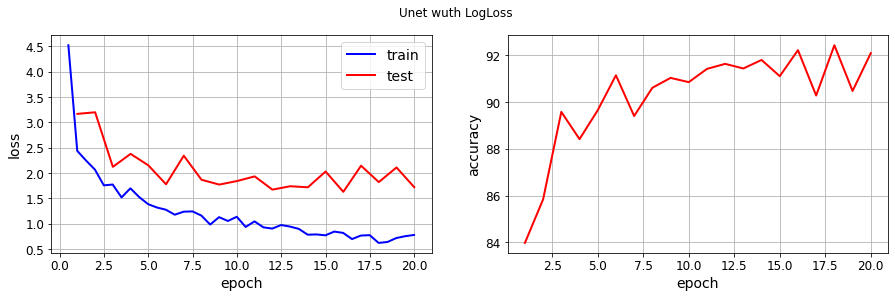

In [658]:
plt_graphics(unet_logloss_data, 'Unet with LogLoss')

In [659]:
#!g1.1
unet = unet.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data

        images = images.to(device)

        outputs = unet(images).to('cpu')

        print(outputs.shape)
        break


torch.Size([8, 1, 320, 240])


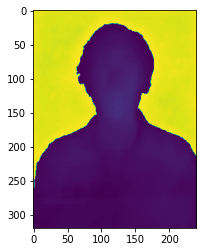

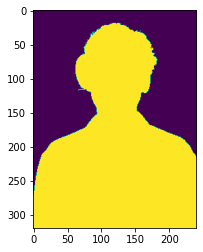

In [660]:
plt.imshow(outputs[0].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[0][0] )
plt.show()

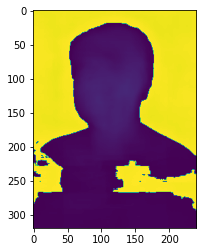

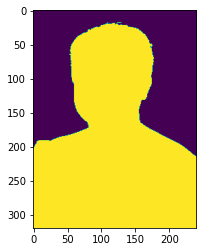

In [661]:
plt.imshow(outputs[1].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[1][0] )
plt.show()

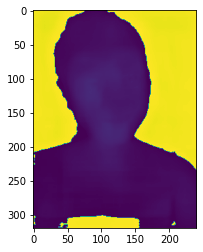

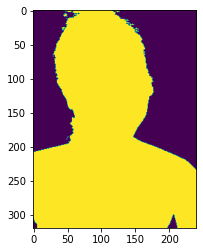

In [662]:
plt.imshow(outputs[2].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[2][0] )
plt.show()

In [663]:
#!g1.1
unet = UNet()
criterion_logloss = DiceLoss(reduction='mean')
optimizer = optim.Adam(unet.parameters(), lr=1e-4, weight_decay=1e-4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

unet_diceloss_data = optimize_net(
    unet, optimizer, criterion_logloss, iou(),
    train_data_loader, test_data_loader, 
    n_epochs=20, device=device
)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg13-19584684.pth



[0.49] loss: 0.036
[0.99] loss: 0.034
[1] test_accuracy: 0.604, test_loss: 0.033
------------------------------
[1.49] loss: 0.033
[1.99] loss: 0.035
[2] test_accuracy: 0.604, test_loss: 0.033
------------------------------
[2.49] loss: 0.034
[2.99] loss: 0.034
[3] test_accuracy: 0.604, test_loss: 0.033
------------------------------
[3.49] loss: 0.034
[3.99] loss: 0.034
[4] test_accuracy: 0.604, test_loss: 0.033
------------------------------
[4.49] loss: 0.032
[4.99] loss: 0.019
[5] test_accuracy: 0.748, test_loss: 0.020
------------------------------
[5.49] loss: 0.013
[5.99] loss: 0.010
[6] test_accuracy: 0.821, test_loss: 0.013
------------------------------
[6.49] loss: 0.010
[6.99] loss: 0.008
[7] test_accuracy: 0.820, test_loss: 0.013
------------------------------
[7.49] loss: 0.008
[7.99] loss: 0.008
[8] test_accuracy: 0.845, test_loss: 0.011
------------------------------
[8.49] loss: 0.008
[8.99] loss: 0.007
[9] test_accuracy: 0.816, test_loss: 0.014
----------------------

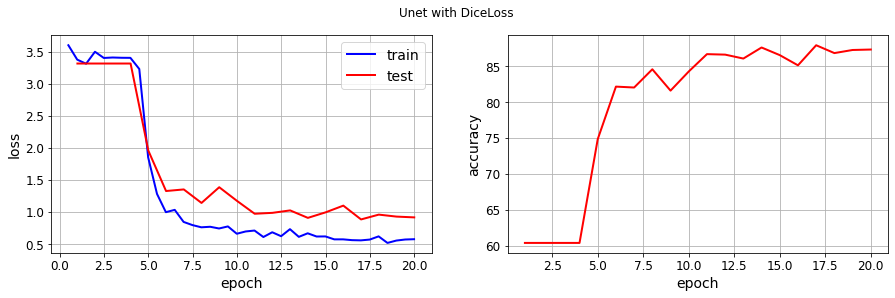

In [664]:
#!g1.1
plt_graphics(unet_diceloss_data, 'Unet with DiceLoss')

In [671]:
#!g1.1
unet = unet.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data

        images = images.to(device)

        outputs = unet(images).to('cpu')

        print(outputs.shape)
        break
images = images.to('cpu')


torch.Size([8, 1, 320, 240])


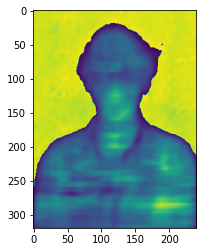

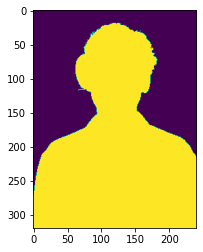

In [673]:

plt.imshow(outputs[0].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[0][0] )
plt.show()

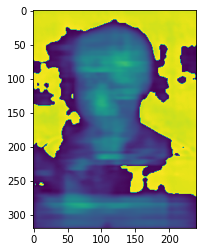

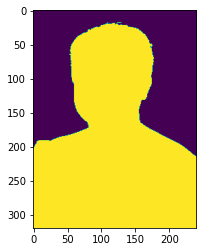

In [667]:
plt.imshow(outputs[1].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[1][0] )
plt.show()

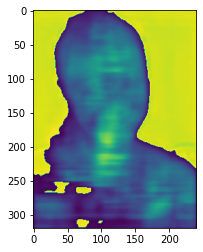

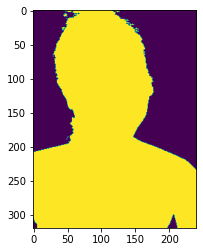

In [668]:
#!g1.1
plt.imshow(outputs[2].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[2][0] )
plt.show()

In [634]:
#!g1.1
class Dice_Log_Loss(nn.Module):
    def __init__(self, weight=0.5, eps=1e-7, reduction='mean', with_logits=True):
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        self.weight = weight
        
    def forward(self, logits, true_labels):
        logloss = nn.BCEWithLogitsLoss()
        diceloss = DiceLoss(self.eps, self.reduction, self.with_logits)
        loss_value_dice = diceloss.forward(logits, true_labels)
        loss_value_log =  logloss(logits, true_labels)
        val =  self.weight*loss_value_dice + (1 - self.weight)*loss_value_log
        return val

In [635]:
#!g1.1
unet = UNet()
criterion_logloss = Dice_Log_Loss()
optimizer = optim.Adam(unet.parameters(), lr=1e-4, weight_decay=1e-4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

unet_dice_log_loss_data = optimize_net(
    unet, optimizer, criterion_logloss, iou(),
    train_data_loader, test_data_loader, 
    n_epochs=20, device=device
)

[0.49] loss: 0.033
[0.99] loss: 0.020
[1] test_accuracy: 0.864, test_loss: 0.020
------------------------------
[1.49] loss: 0.015
[1.99] loss: 0.014
[2] test_accuracy: 0.886, test_loss: 0.018
------------------------------
[2.49] loss: 0.013
[2.99] loss: 0.012
[3] test_accuracy: 0.902, test_loss: 0.015
------------------------------
[3.49] loss: 0.011
[3.99] loss: 0.012
[4] test_accuracy: 0.888, test_loss: 0.018
------------------------------
[4.49] loss: 0.010
[4.99] loss: 0.011
[5] test_accuracy: 0.891, test_loss: 0.017
------------------------------
[5.49] loss: 0.010
[5.99] loss: 0.010
[6] test_accuracy: 0.905, test_loss: 0.014
------------------------------
[6.49] loss: 0.009
[6.99] loss: 0.009
[7] test_accuracy: 0.906, test_loss: 0.014
------------------------------
[7.49] loss: 0.008
[7.99] loss: 0.007
[8] test_accuracy: 0.918, test_loss: 0.013
------------------------------
[8.49] loss: 0.007
[8.99] loss: 0.009
[9] test_accuracy: 0.918, test_loss: 0.012
-----------------------

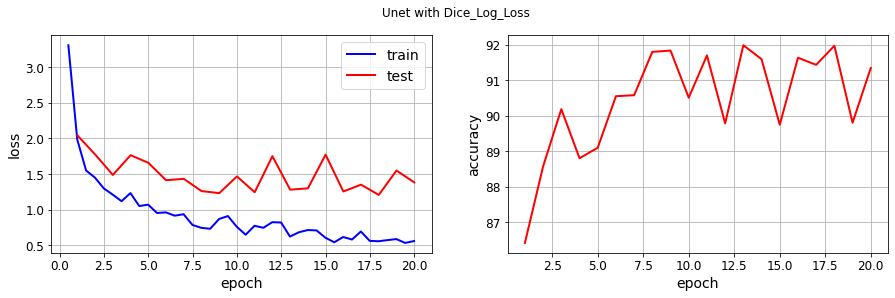

In [636]:
plt_graphics(unet_dice_log_loss_data, 'Unet with Dice_Log_Loss')

torch.Size([8, 1, 320, 240])


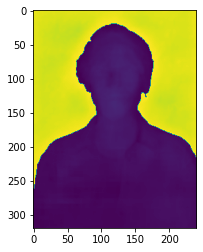

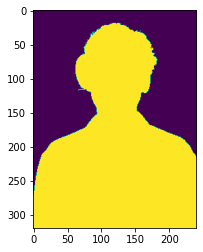

In [654]:
#!g1.1
unet = unet.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data

        images = images.to(device)

        outputs = unet(images).to('cpu')

        print(outputs.shape)
        break

plt.imshow(outputs[0].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[0][0] )
plt.show()

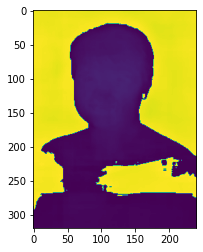

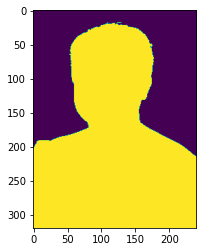

In [655]:
plt.imshow(outputs[1].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[1][0] )
plt.show()

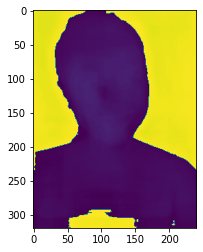

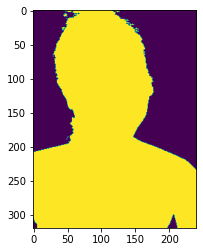

In [656]:
plt.imshow(outputs[2].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[2][0] )
plt.show()

**Вывод:**

У всех трех методов Loss выходит на плато. Когда используется только кросс-энтропия, то loss выходит на минимум примерно на 15 эпохе, а у Diceloss примерно на 10 эпохе. То есть нейросеть с Diceloss сходится быстрее. Также можно заметить, что графики с DiceLoss колеблятся меньше. Это говорит о том, что такой подход является более устойчивым.

По выведенным картинкам можно заметить, что у картинок Logloss есть "четкая" граница, а Diceloss выводит картинки такие, чтопрослеживается очертание силуэта, но оно с некоторой погрешностью. Границы не четкие, поэтому итоговое качество на метрике IoU у Diceloss хуже, чем у LogLoss.

При применении обоих подходов, регулируя вес, с которым берутся функции, алгоритм будет сходиться быстро (засчет Diceloss), а итоговые маски будут "четкими" (засчет Logloss).

## LinkNet (2 балла)

In [682]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[
                    feature_extractor[j]
                    for j in range(i * 5, i * 5 + 4)
                ])
            )

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations
    
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(left + x))
        x = self.relu(self.conv2(x))
        return x


class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

Обучите сеть и проведите анализ согласно предыдущему пункту.

In [683]:
#!g1.1
# your code here
import torch.optim as optim
linknet_1 = UNet()
criterion_logloss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(linknet_1.parameters(), lr=1e-4, weight_decay=1e-4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

linknet_logloss_data = optimize_net(
    linknet_1, optimizer, criterion_logloss, iou(),
    train_data_loader, test_data_loader, 
    n_epochs=20, device=device
)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg13-19584684.pth



[0.49] loss: 0.040
[0.99] loss: 0.024
[1] test_accuracy: 0.859, test_loss: 0.029
------------------------------
[1.49] loss: 0.022
[1.99] loss: 0.020
[2] test_accuracy: 0.864, test_loss: 0.027
------------------------------
[2.49] loss: 0.018
[2.99] loss: 0.018
[3] test_accuracy: 0.886, test_loss: 0.023
------------------------------
[3.49] loss: 0.016
[3.99] loss: 0.015
[4] test_accuracy: 0.897, test_loss: 0.021
------------------------------
[4.49] loss: 0.016
[4.99] loss: 0.015
[5] test_accuracy: 0.904, test_loss: 0.019
------------------------------
[5.49] loss: 0.012
[5.99] loss: 0.013
[6] test_accuracy: 0.909, test_loss: 0.018
------------------------------
[6.49] loss: 0.013
[6.99] loss: 0.012
[7] test_accuracy: 0.909, test_loss: 0.018
------------------------------
[7.49] loss: 0.012
[7.99] loss: 0.012
[8] test_accuracy: 0.905, test_loss: 0.019
------------------------------
[8.49] loss: 0.011
[8.99] loss: 0.011
[9] test_accuracy: 0.913, test_loss: 0.019
----------------------

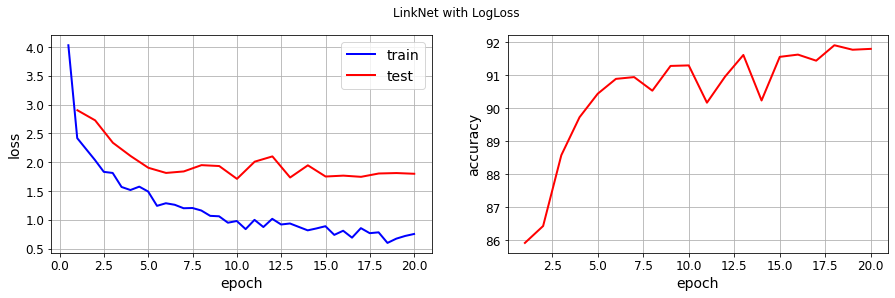

In [687]:
plt_graphics(linknet_logloss_data, 'LinkNet with LogLoss')

In [688]:
#!g1.1
linknet_1 = linknet_1.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data

        images = images.to(device)

        outputs =linknet_1(images).to('cpu')

        print(outputs.shape)
        break


torch.Size([8, 1, 320, 240])


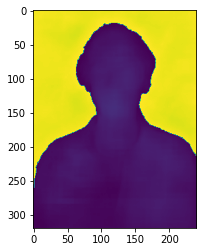

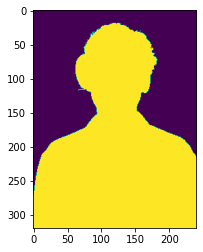

In [689]:
#!g1.1
plt.imshow(outputs[0].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[0][0] )
plt.show()

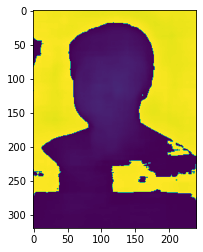

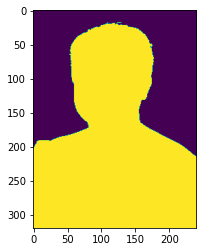

In [690]:
#!g1.1
plt.imshow(outputs[1].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[1][0] )
plt.show()

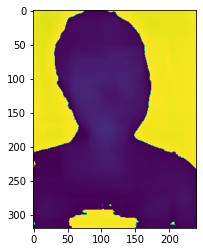

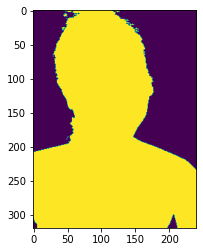

In [691]:
#!g1.1
plt.imshow(outputs[2].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[2][0] )
plt.show()

In [692]:
#!g1.1
linknet_2 = UNet()
criterion_logloss = DiceLoss(reduction='mean')
optimizer = optim.Adam(linknet_2.parameters(), lr=1e-4, weight_decay=1e-4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

linknet_diceloss_data = optimize_net(
    linknet_2, optimizer, criterion_logloss, iou(),
    train_data_loader, test_data_loader, 
    n_epochs=20, device=device
)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg13-19584684.pth



[0.49] loss: 0.025
[0.99] loss: 0.011
[1] test_accuracy: 0.835, test_loss: 0.012
------------------------------
[1.49] loss: 0.009
[1.99] loss: 0.007
[2] test_accuracy: 0.862, test_loss: 0.010
------------------------------
[2.49] loss: 0.007
[2.99] loss: 0.007
[3] test_accuracy: 0.881, test_loss: 0.008
------------------------------
[3.49] loss: 0.006
[3.99] loss: 0.006
[4] test_accuracy: 0.885, test_loss: 0.008
------------------------------
[4.49] loss: 0.006
[4.99] loss: 0.006
[5] test_accuracy: 0.903, test_loss: 0.007
------------------------------
[5.49] loss: 0.006
[5.99] loss: 0.006
[6] test_accuracy: 0.901, test_loss: 0.007
------------------------------
[6.49] loss: 0.005
[6.99] loss: 0.005
[7] test_accuracy: 0.905, test_loss: 0.007
------------------------------
[7.49] loss: 0.005
[7.99] loss: 0.005
[8] test_accuracy: 0.887, test_loss: 0.008
------------------------------
[8.49] loss: 0.004
[8.99] loss: 0.005
[9] test_accuracy: 0.900, test_loss: 0.007
----------------------

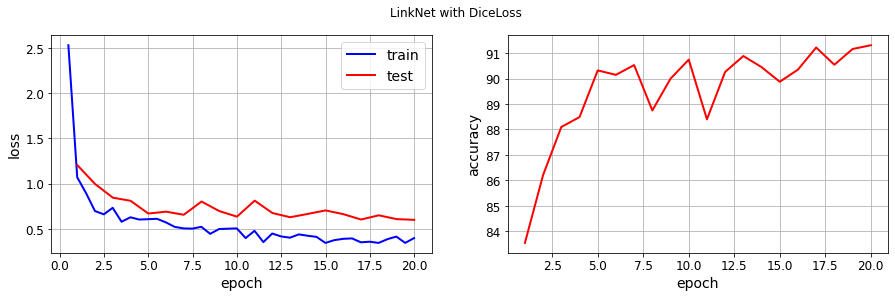

In [693]:
plt_graphics(linknet_diceloss_data, 'LinkNet with DiceLoss')

In [694]:
#!g1.1
linknet_2 = linknet_2.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data

        images = images.to(device)

        outputs = linknet_2(images).to('cpu')

        print(outputs.shape)
        break

torch.Size([8, 1, 320, 240])


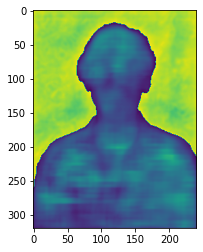

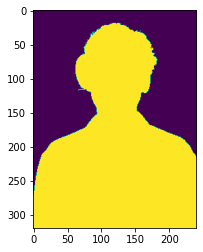

In [695]:
plt.imshow(outputs[0].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[0][0] )
plt.show()

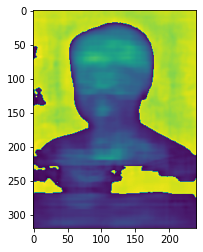

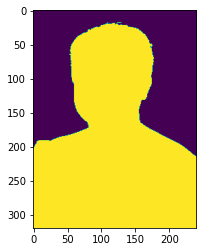

In [696]:
plt.imshow(outputs[1].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[1][0] )
plt.show()

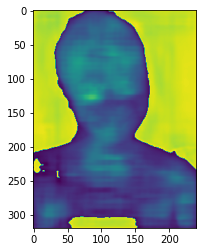

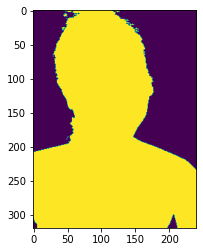

In [697]:
plt.imshow(outputs[2].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[2][0] )
plt.show()

In [698]:
#!g1.1
linknet_3 = UNet()
criterion_logloss = Dice_Log_Loss()
optimizer = optim.Adam(linknet_3 .parameters(), lr=1e-4, weight_decay=1e-4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

linknet_dice_log_loss_data = optimize_net(
    linknet_3 , optimizer, criterion_logloss, iou(),
    train_data_loader, test_data_loader, 
    n_epochs=20, device=device
)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg13-19584684.pth



[0.49] loss: 0.031
[0.99] loss: 0.018
[1] test_accuracy: 0.858, test_loss: 0.022
------------------------------
[1.49] loss: 0.017
[1.99] loss: 0.015
[2] test_accuracy: 0.889, test_loss: 0.017
------------------------------
[2.49] loss: 0.012
[2.99] loss: 0.013
[3] test_accuracy: 0.878, test_loss: 0.019
------------------------------
[3.49] loss: 0.012
[3.99] loss: 0.011
[4] test_accuracy: 0.889, test_loss: 0.016
------------------------------
[4.49] loss: 0.011
[4.99] loss: 0.010
[5] test_accuracy: 0.906, test_loss: 0.014
------------------------------
[5.49] loss: 0.010
[5.99] loss: 0.009
[6] test_accuracy: 0.906, test_loss: 0.015
------------------------------
[6.49] loss: 0.009
[6.99] loss: 0.010
[7] test_accuracy: 0.908, test_loss: 0.014
------------------------------
[7.49] loss: 0.009
[7.99] loss: 0.009
[8] test_accuracy: 0.895, test_loss: 0.016
------------------------------
[8.49] loss: 0.008
[8.99] loss: 0.009
[9] test_accuracy: 0.905, test_loss: 0.014
----------------------

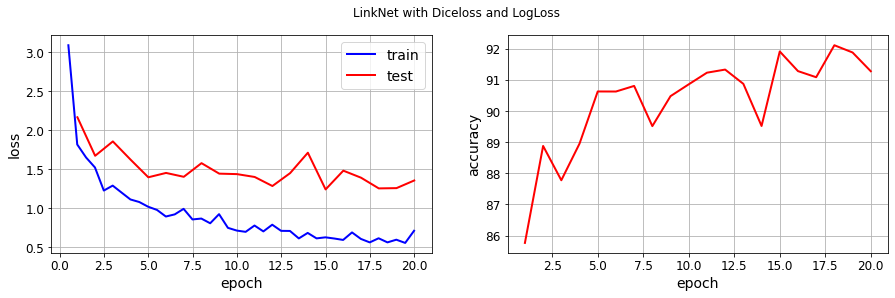

In [699]:
#!g1.1
plt_graphics(linknet_dice_log_loss_data, 'LinkNet with Diceloss and LogLoss')

In [700]:
#!g1.1
linknet_3 = linknet_3.eval()

with torch.no_grad():
    for data in test_data_loader:
        images, labels = data

        images = images.to(device)

        outputs = linknet_3(images).to('cpu')

        print(outputs.shape)
        break

torch.Size([8, 1, 320, 240])


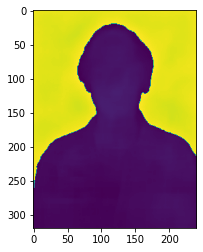

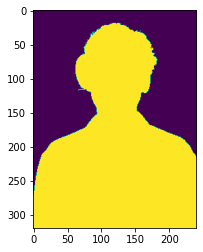

In [701]:
#!g1.1
plt.imshow(outputs[0].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[0][0] )
plt.show()

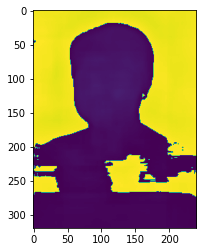

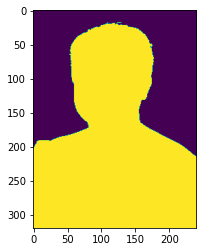

In [702]:
#!g1.1
plt.imshow(outputs[1].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[1][0] )
plt.show()

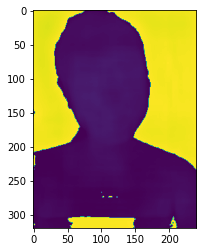

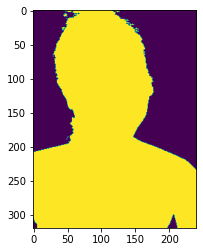

In [703]:
#!g1.1
plt.imshow(outputs[2].permute(1, 2, 0).to(torch.uint8) )
plt.show()

plt.imshow(labels[2][0] )
plt.show()

**Вывод:**

Когда используется только кросс-энтропия, то loss выходит на минимум примерно на 17,5 эпохе, а у Diceloss примерно на 12,5 эпохе. То есть нейросеть с Diceloss сходится быстрее. 

Здесь как и при использовании Unet при применении обоих подходов, регулируя вес, с которым берутся функции, алгоритм будет сходиться быстро (засчет Diceloss), а итоговые маски будут "четкими" (засчет Logloss).

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

**Вывод:**
В данном случае LinkNet сходиться дольше, чем Unet и в методе Diceloss и в методе LogLoss (примерно на 5 эпох). Ошибки допускают нейросети такие же(этот вывод можно сделать по высвеченным картинкам). Оба метода дают одинаковый лосс по истечению 20-ти эпох. Также они не сильно отличаются в достижении точности с метрикой IoU. Но при использовании Unet c Diceloss каечство немного хуже, чем в остальных случаях. В LinkNet такого не наблюдается.

В данном случае удобнее применять сеть Unet так как она быстрее сходится, но даёт практически тако же результат.


## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

*Ваш ответ в этой ячейке*

Архитектура свёрточных сетей опирается на то, что в данных будут некоторые закономерности, последовательности со сдвигом, которые ей удасться выделить и таким образом создать новые признаки. Когда есть локальная связь меду данными(например, между соседними пискелями в изображениях). Но если все признаки между собой независимы, то сверточная есть будет плохо работать на таком наборе данных. Например, если взять изображение, которое будет примерно одинаковое во всех частях, то сверточная сеть будет работать плохо. Одно из преимуществ применения нейронных сетей  - это уменьшение количества обучаемых параметров, следовательно, и уменьшение вычислительной сложности, также качество при применении сверток может улучшиться. 

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

*Ваш ответ в этой ячейке*


Размерность выходного пространства.


для f: $\mathbb{R}^{1000}$, так как перемножаются матрица размерности ${1000\times 100}$ и вектор весов размерности $\mathbb{R}^{100}$


для g: $\mathbb{R}^{100}$, при применении свертки мы получаем вектор размерности 98 и за счет того, что  паддинг равен 1, вектор превращается в вектор исходного размера.


Количество обучаемых параметров.


для f: 100 000 - количество элементов в матрице параметров


для g: 3*10 = 30, в каждой свертке по 3 параметра, всего 10 сверток


Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).


для f: 1000*199 = 199 000, при умножении строки на вектор - 100 умножений и 99 сложений. Таких операций 1 000. Ещё надо умножить на параметр p - где p - применение функции активации. Итого: 199 000 + 100 000p


для g: при применении одной операции свертки - 3 умножения и 2 сложения (5 операций), для одного вектора размера 100 - 98*5. Мы применяем 10 раз к вектору свертки - 98*5*100. И ещё применяем функцию активации к матрице размера ${100\times 10}$. Итого: 98*5*100 + 1000р = 49 000 + 1000р


## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).